
# Tutorial Goal

This tutorial aims to show some example of **trace analysis and visualization**
using a pre-defined set of analysis and plotting functions provided by the
**Filters** and **Trace** modules of LISA.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

In [2]:
# Generate plots inline
%matplotlib inline

# Python modules required by this notebook
import json
import os

# Configuration

In [3]:
# Let's use an example trace
res_dir = './example_results'
tracefile = os.path.join(res_dir, 'trace.dat')
platformfile = os.path.join(res_dir, 'platform.json')
!tree {res_dir}

./example_results
├── cluster_freqs.png
├── ediff_stats.png
├── ediff_time.png
├── platform.json
├── task_util_20331_sh.png
├── task_util_20552_chrome.png
├── task_util_20615_chrome.png
├── task_util_20672_keygen.png
├── task_util_20678_df.png
├── task_util_20687_chrome.png
├── task_util_20705_chrome.png
├── task_util_20803_sh.png
├── task_util_20805_lsof.png
├── task_util_650_permission_brok.png
├── task_util_chrome.png
├── task_util_keygen.png
├── task_util_lsof.png
├── trace.dat
├── trace.raw.txt
└── trace.txt

0 directories, 20 files


In [4]:
# Trace events of interest
events_to_parse = [
    "sched_switch",
    "sched_wakeup",
    "sched_wakeup_new",
    "sched_contrib_scale_f",
    "sched_load_avg_cpu",
    "sched_load_avg_task",
    "sched_tune_config",
    "sched_tune_tasks_update",
    "sched_tune_boostgroup_update",
    "sched_tune_filter",
    "sched_boost_cpu",
    "sched_boost_task",
    "sched_energy_diff",
    "cpu_frequency",
    "cpu_capacity",
]

# Platform description
with open(platformfile, 'r') as fh:
    platform = json.load(fh)

logging.info("CPUs max capacities:")
logging.info("   big: %5d (cpus: %s)",
             platform['nrg_model']['big']['cpu']['cap_max'],
             platform['clusters']['big'])
logging.info("LITTLE: %5d (cpus: %s)",
             platform['nrg_model']['little']['cpu']['cap_max'],
             platform['clusters']['little'])

# Time range from the analysis
(t_min, t_max) = (0, None)

05:45:57  INFO    : CPUs max capacities:
05:45:57  INFO    :    big:  1024 (cpus: [2, 3])
05:45:57  INFO    : LITTLE:   591 (cpus: [0, 1])


# Trace parsing

In [5]:
# Load the LISA::Trace parsing module
from trace import Trace


# The LISA::Trace module is a wrapper of the TRAPpy FTrace module which
# allows to keep track of platform specific details to support the generation
# of
trace = Trace(res_dir, events_to_parse, platform, window=(t_min,t_max))

05:45:58  INFO    : Parsing FTrace format...
05:46:29  INFO    : Platform clusters verified to be Frequency coherent
05:46:29  INFO    : Collected events spans a 35.314 [s] time interval
05:46:29  INFO    : Set plots time range to (0.000000, 35.313536)[s]
05:46:29  INFO    : Registering trace analysis modules:
05:46:29  WARNING :       No performance data found in:
05:46:29  WARNING :         ./example_results
05:46:29  INFO    :    perf
05:46:29  INFO    :    eas
05:46:29  INFO    :    tasks
05:46:29  INFO    :    cpus
05:46:29  INFO    :    functions
05:46:29  INFO    :    status
05:46:29  INFO    :    frequency


Maximum estimated system energy: 3102


Notice how some platform specific data are collected and reported by the
LISA::Trace module

In [6]:
# This is the standard TRAPpy::FTrace object, already configured for the
# analysis related to the events of interest
ftrace = trace.ftrace
logging.info("List of events identified in the trace:")
for event in ftrace.class_definitions.keys():
    logging.info("   %s", event)

05:46:29  INFO    : List of events identified in the trace:
05:46:29  INFO    :    sched_load_avg_task
05:46:29  INFO    :    cpu_frequency
05:46:29  INFO    :    cpu_capacity
05:46:29  INFO    :    sched_tune_boostgroup_update
05:46:29  INFO    :    sched_load_avg_cpu
05:46:29  INFO    :    sched_boost_cpu
05:46:29  INFO    :    sched_wakeup_new
05:46:29  INFO    :    sched_tune_config
05:46:29  INFO    :    sched_boost_task
05:46:29  INFO    :    sched_tune_tasks_update
05:46:29  INFO    :    sched_tune_filter
05:46:29  INFO    :    sched_energy_diff
05:46:29  INFO    :    sched_switch
05:46:29  INFO    :    sched_contrib_scale_f
05:46:29  INFO    :    sched_wakeup


In [7]:
# Original TRAPpy::FTrace DataSet are still accessible by specifying the
# trace event name of interest
trace.data_frame.trace_event('sched_load_avg_task').head()

,__comm,__cpu,__pid,comm,cpu,load_avg,load_sum,period_contrib,pid,util_avg,util_sum,cluster,min_cluster_cap
Time,,,,,,,,,,,,,
0.000014,<...>,1,20278,trace-cmd,1,58,2811439,916,20278,33,1601714,LITTLE,591
0.000229,<...>,1,20278,trace-cmd,1,59,2820191,111,20278,33,1612418,LITTLE,591
0.000334,<idle>,0,0,sh,0,0,0,957,20277,0,0,LITTLE,591
0.000982,sh,0,20277,sh,0,5,285169,710,20277,3,164585,LITTLE,591
0.001178,sh,0,20277,sh,0,5,355825,903,20277,3,205364,LITTLE,591


# LISA Tasks Filtering Functions

In [8]:
trace.setXTimeRange(t_min, t_max)

05:46:29  INFO    : Set plots time range to (0.000000, 35.313536)[s]


## Top BIG tasks

In [9]:
# Get a list of tasks which are the most big in the trace
top_big_tasks = trace.data_frame.top_big_tasks(
    min_utilization=None, # Minimum utilization to be considered "big"
                          # default: LITTLE CPUs max capacity
    min_samples=100,      # Number of samples over the minimum utilization 
)

05:46:29  INFO    :   120 tasks with samples of utilization > 591
05:46:30  INFO    :       10 with more than 100 samples


In [10]:
# The collected information is available for further analysis
top_big_tasks

,samples,comm
pid,,
20672,2426,"keygen, session_manager"
20705,1866,chrome
20803,662,"sh, lsof"
20615,587,chrome
20805,576,lsof
20331,440,"sh, lsof"
650,290,permission_brok
20552,157,"chrome, Chrome_IOThread"
20678,136,"df, sshd, bash"


05:46:30  INFO    :   120 tasks with samples of utilization > 591
05:46:31  INFO    :       10 with more than 100 samples
05:46:31  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:31  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:31  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:31  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:31  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:32  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:32  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:32  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:32  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:32  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:32  INFO    : Tasks which have been a "utilization" of 591 for at least 100 samples


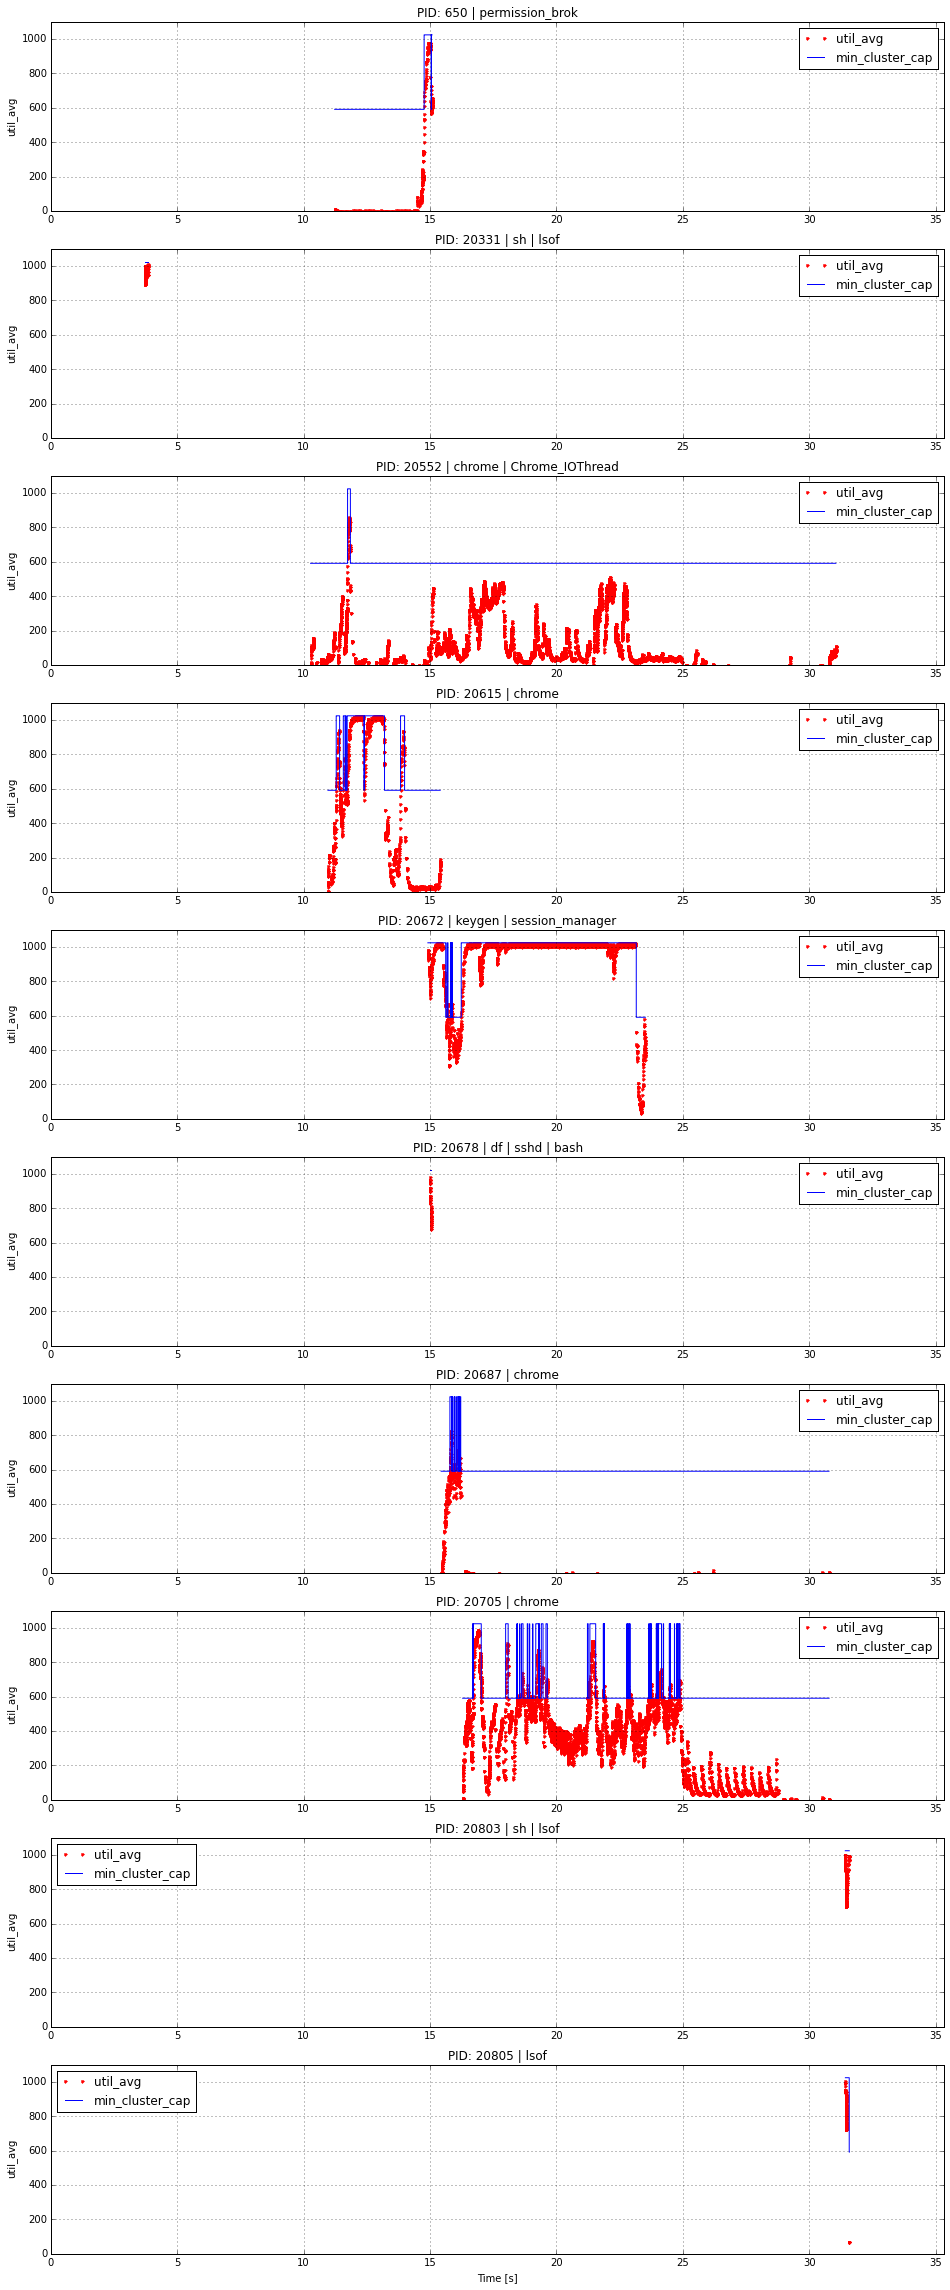

In [11]:
# Plot utilization of "big" tasks decorated with platform specific capacity information
trace.analysis.tasks.plotBigTasks()

## Top WAKEUP tasks

In [12]:
top_wakeup_tasks = trace.data_frame.top_wakeup_tasks(
    min_wakeups=100  # Minimum number of wakeup to be reported
)

05:46:34  INFO    : 81621 tasks with more than 79 wakeups


In [13]:
top_wakeup_tasks.head()

,samples,comm
pid,,
20527,6184,"chrome, session_manager"
1364,5731,ksdioirqd/mmc2
7,5432,rcu_preempt
20552,4192,"chrome, Chrome_IOThread"
20596,4096,"chrome, Chrome_ChildIOT"


### Wakeup vs Forks

05:46:37  INFO    : 81621 tasks with more than 481 wakeups
05:46:39  INFO    : Plotting 10 frequent wakeup tasks
05:46:39  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:39  WARNING : Event [sched_overutilized] not found, plot DISABLED!


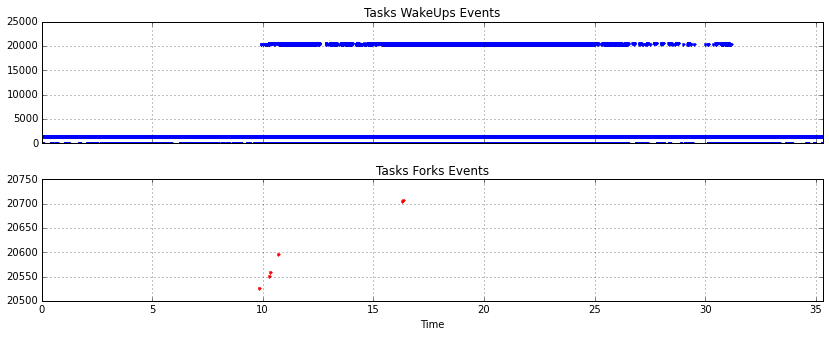

In [14]:
trace.analysis.tasks.plotWakeupTasks(per_cluster=False)

### Wakeup per cluster

05:46:39  INFO    :   653 tasks forked on big cluster    (91.8 %)
05:46:39  INFO    :    58 tasks forked on LITTLE cluster (8.2 %)
05:46:39  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:39  WARNING : Event [sched_overutilized] not found, plot DISABLED!


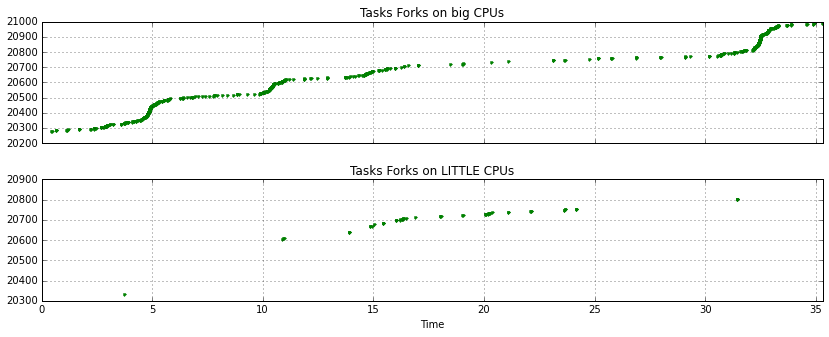

In [15]:
trace.analysis.tasks.plotWakeupTasks(per_cluster=True)

## RT Tasks

In [16]:
trace.data_frame.rt_tasks(min_prio=100)

,prio,comm
pid,,
10,0,migration/0
11,0,watchdog/0
12,0,watchdog/1
13,0,migration/1
17,0,watchdog/2
18,0,migration/2
22,0,watchdog/3
23,0,migration/3
492,0,daisydog


# Predefined LISA analysis Functions

**Trace** class provides an **analysis** object that allows to perform several types of analysis on data contained in the trace. Currently available analysis types are:

| Analysis Object | Description                           |
|-----------------|---------------------------------------|
| `cpus`          | CPUs Analysis                         |
| `eas`           | EAS-specific functionalities Analysis |
| `functions`     | Functions Profiling Analysis          |
| `frequency`     | Frequency Analysis                    |
| `status`        | System Status Analysis                |
| `tasks`         | Tasks Analysis                        |

 
 Those are easily accessible via:
 
 ```python
 trace.analysis.<analysis_object>
 ```

In [17]:
# Define time ranges for all the time based plots
trace.setXTimeRange(t_min, t_max)

05:46:40  INFO    : Set plots time range to (0.000000, 35.313536)[s]


05:46:40  INFO    : Plotting 20672: keygen, session_manager...
05:46:40  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:40  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:40  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:41  INFO    : Plotting 20705: chrome...
05:46:41  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:41  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:41  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:41  INFO    : Plotting 20803: sh, lsof...
05:46:42  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:42  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:42  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:42  INFO    : Plotting 20615: chrome...
05:46:42  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:42  WARNING : Event [sched_overutilized] not found, plot DISA

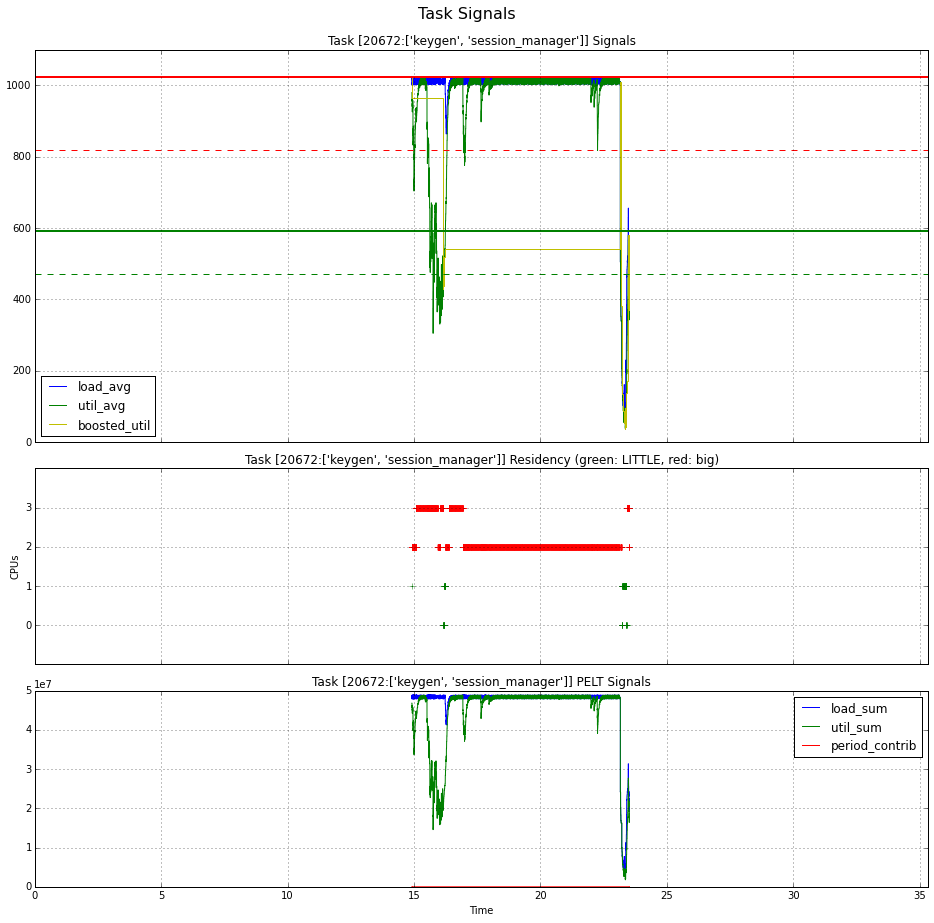

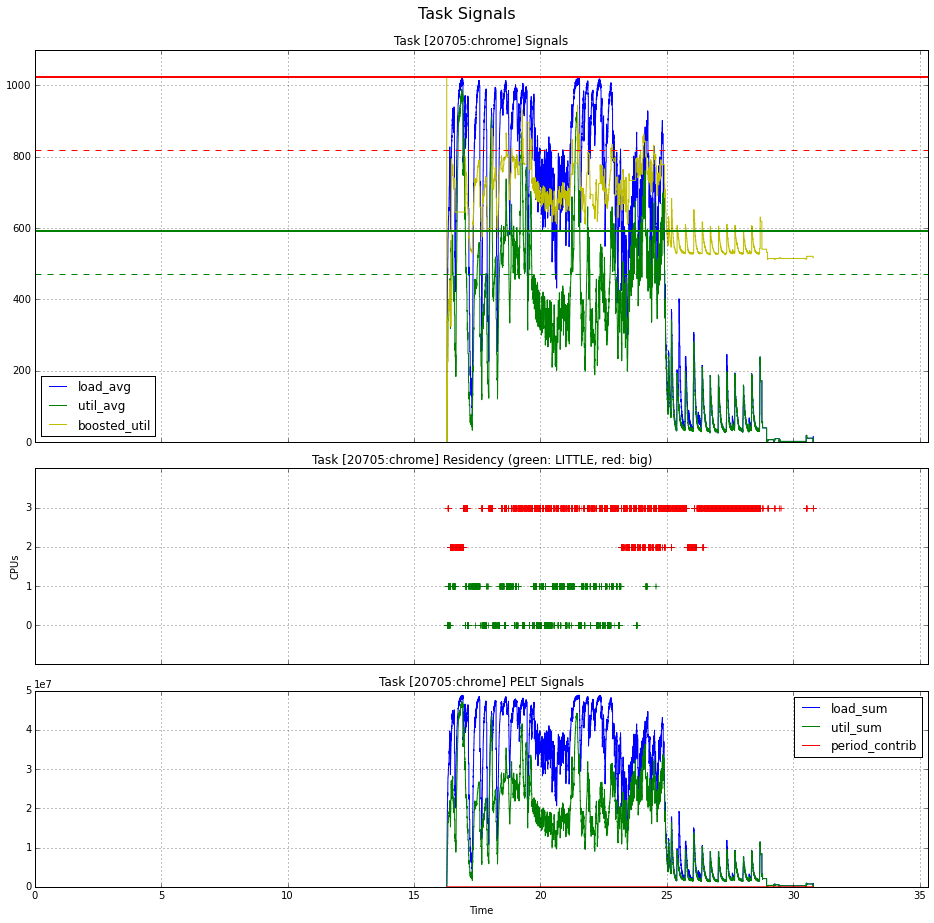

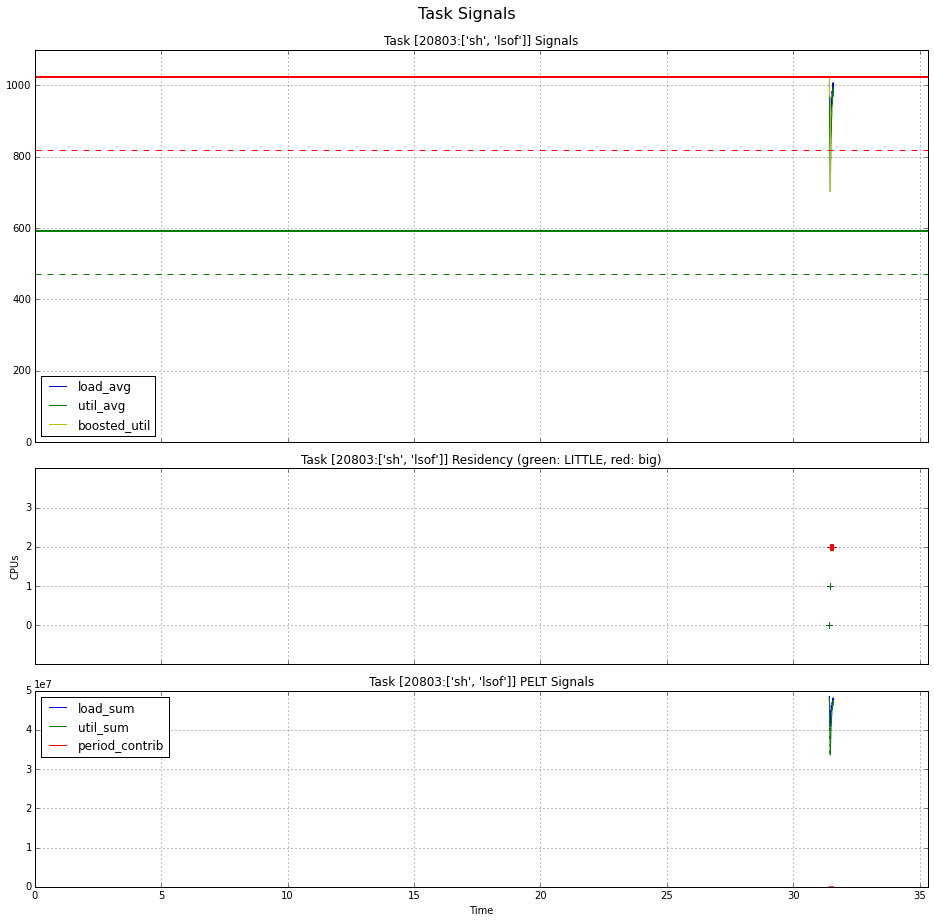

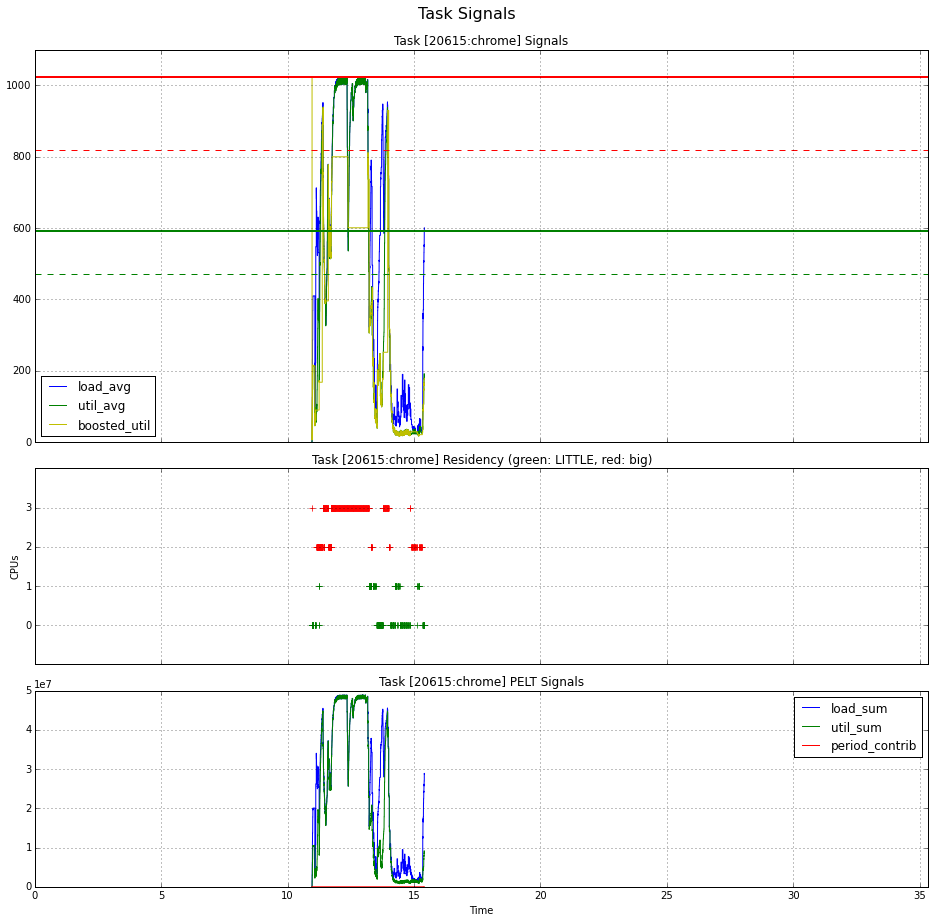

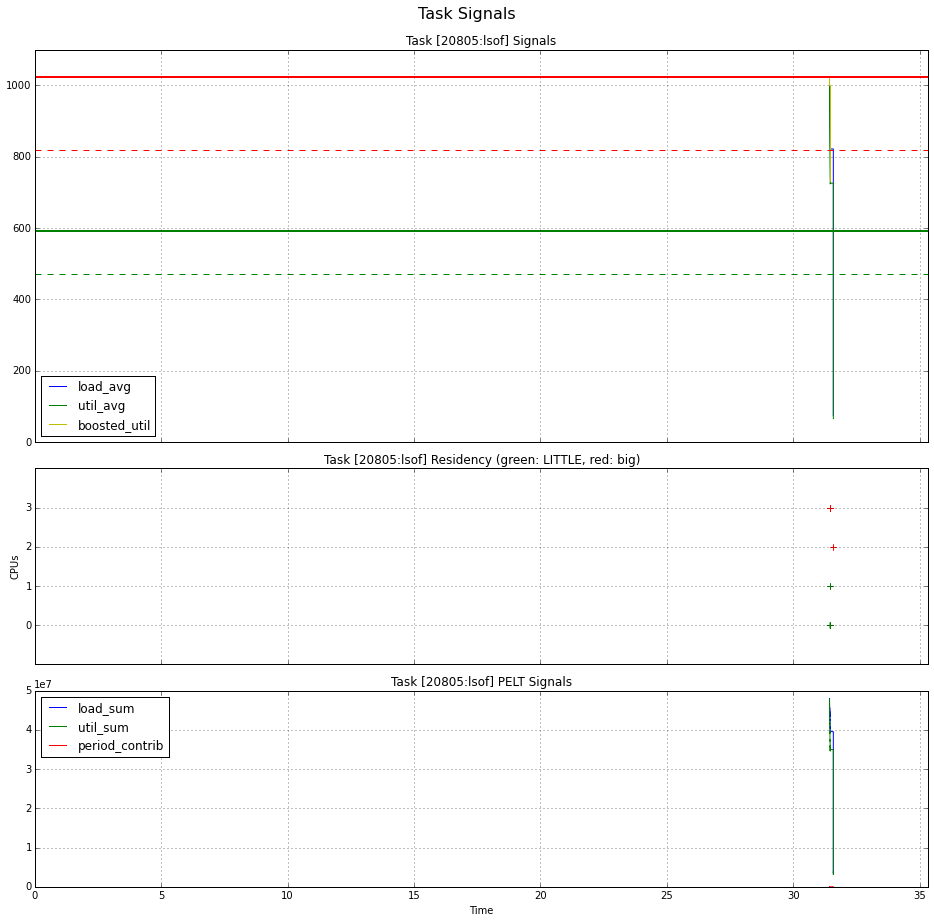

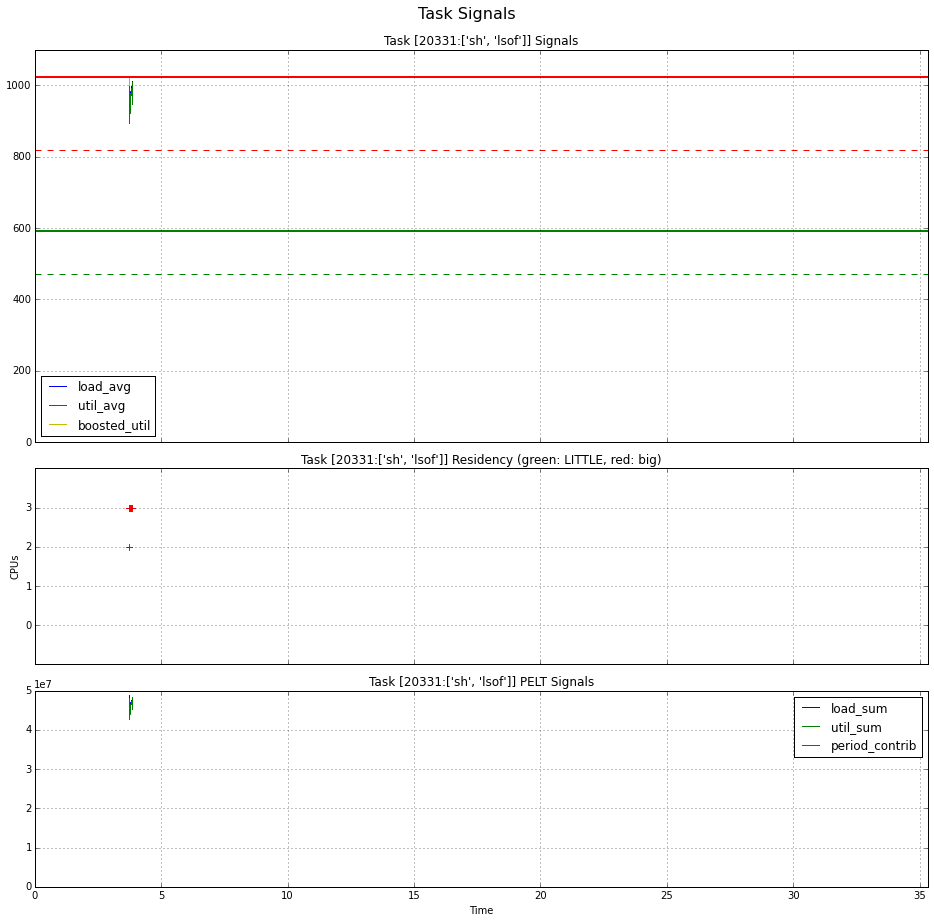

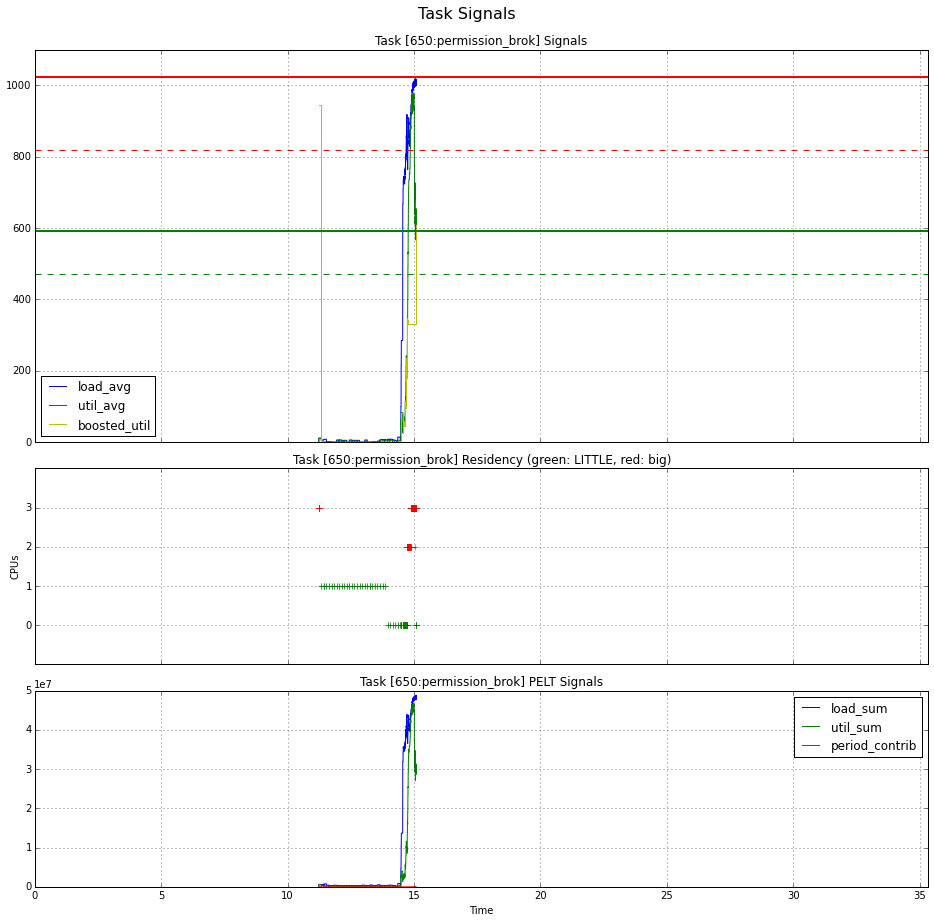

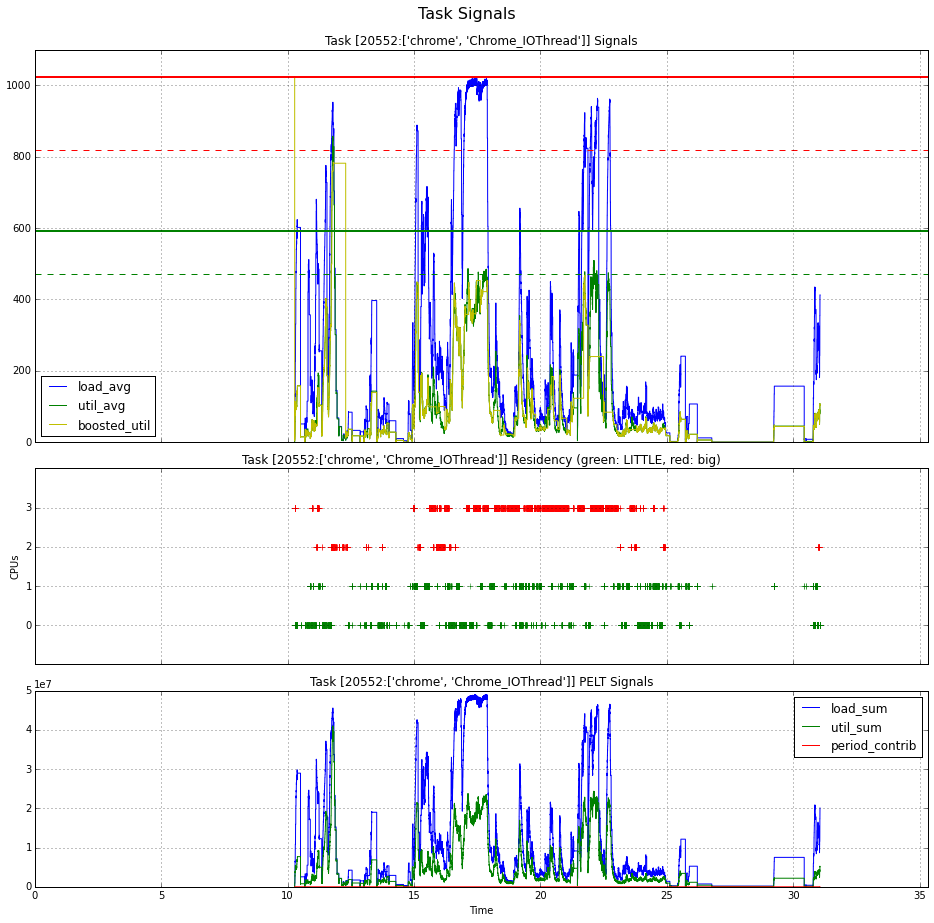

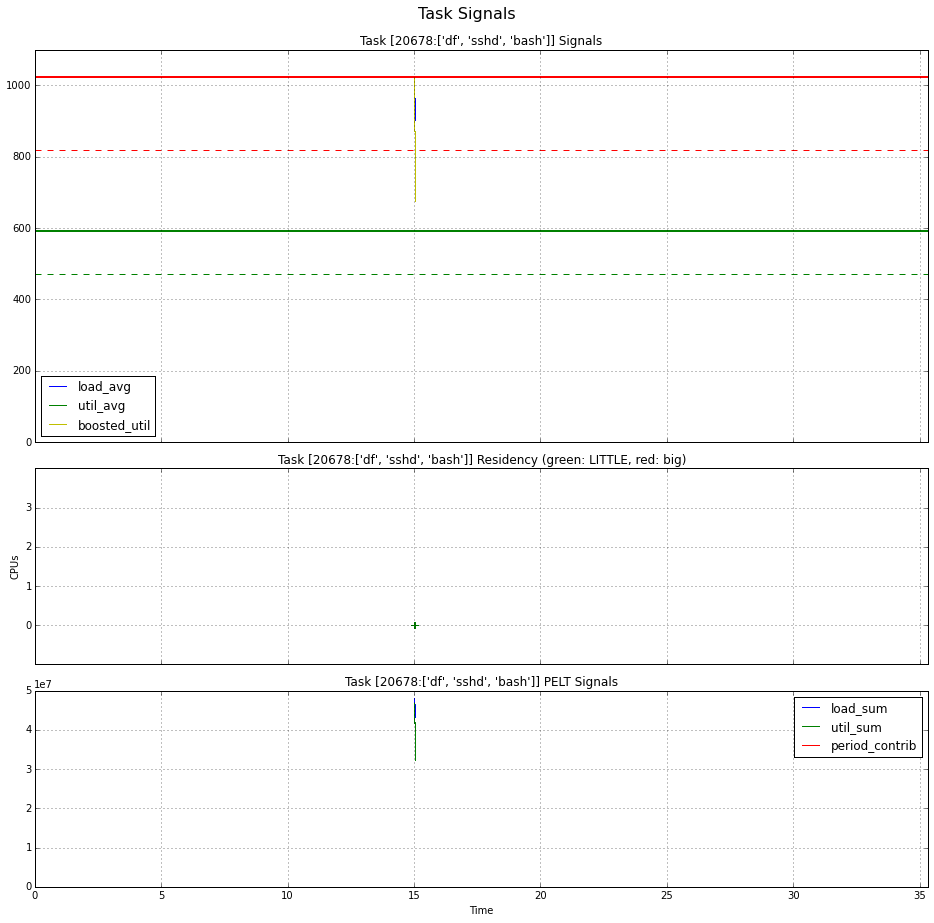

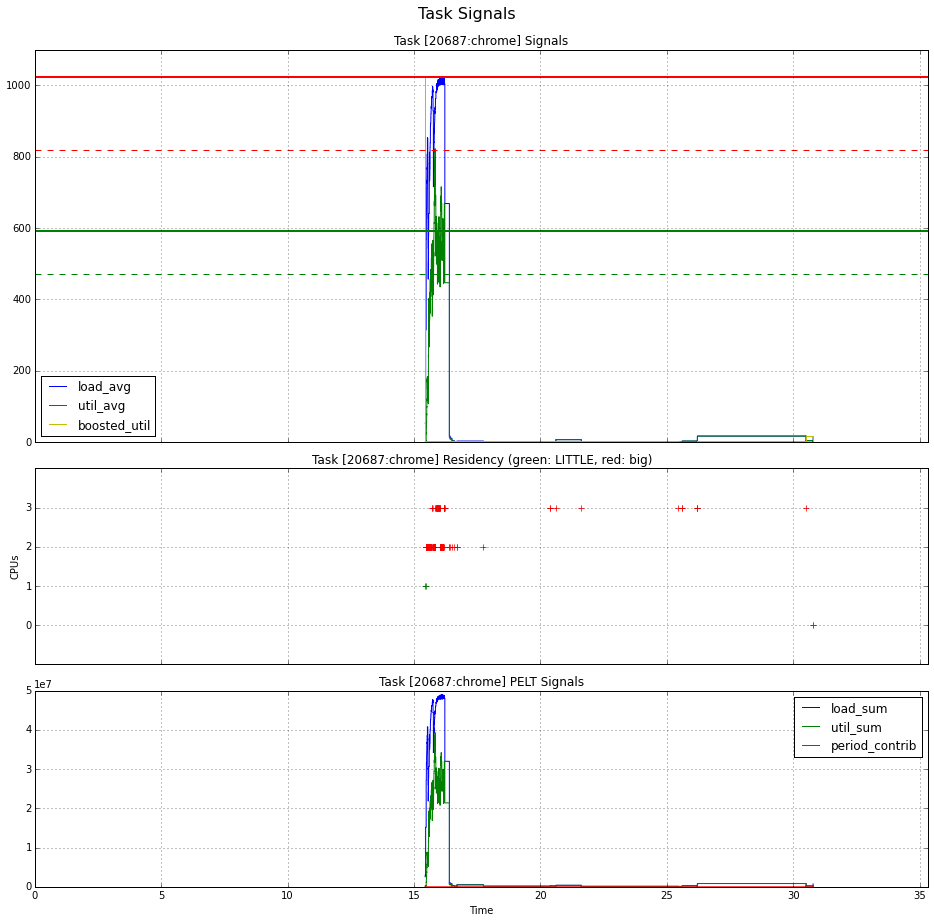

In [18]:
trace.analysis.tasks.plotTasks(top_big_tasks.index.tolist())

05:46:49  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:49  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:49  INFO    : LITTLE cluster average frequency: 0.918 GHz
05:46:49  INFO    : big    cluster average frequency: 1.169 GHz


(0.9176060361706474, 1.1693335360754313)

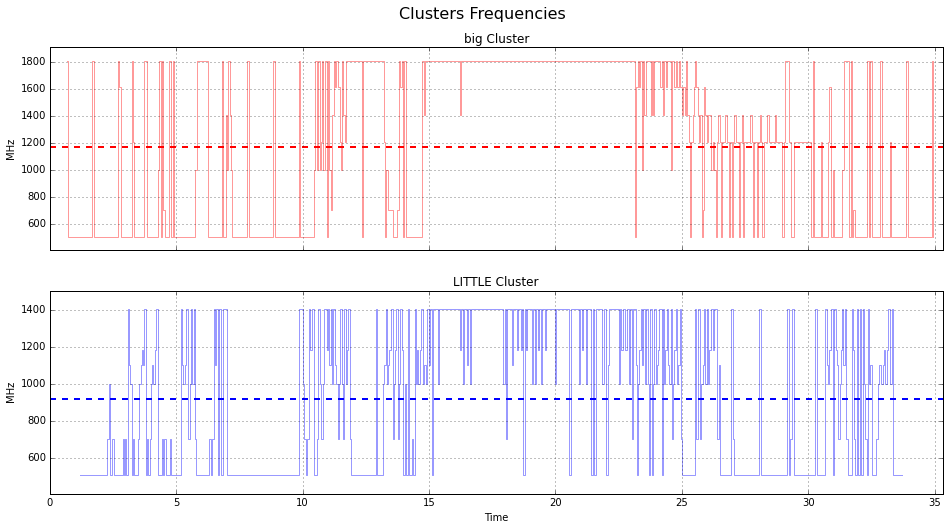

In [19]:
# Cluster frequencies
trace.analysis.frequency.plotClusterFrequencies()

05:46:49  WARNING : Event [sched_overutilized] not found, plot DISABLED!
/usr/lib/python2.7/dist-packages/matplotlib/axes/_base.py:2544: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=25.777079, right=25.777079
  'left=%s, right=%s') % (left, right))
05:46:49  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:49  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:46:50  WARNING : Event [sched_overutilized] not found, plot DISABLED!


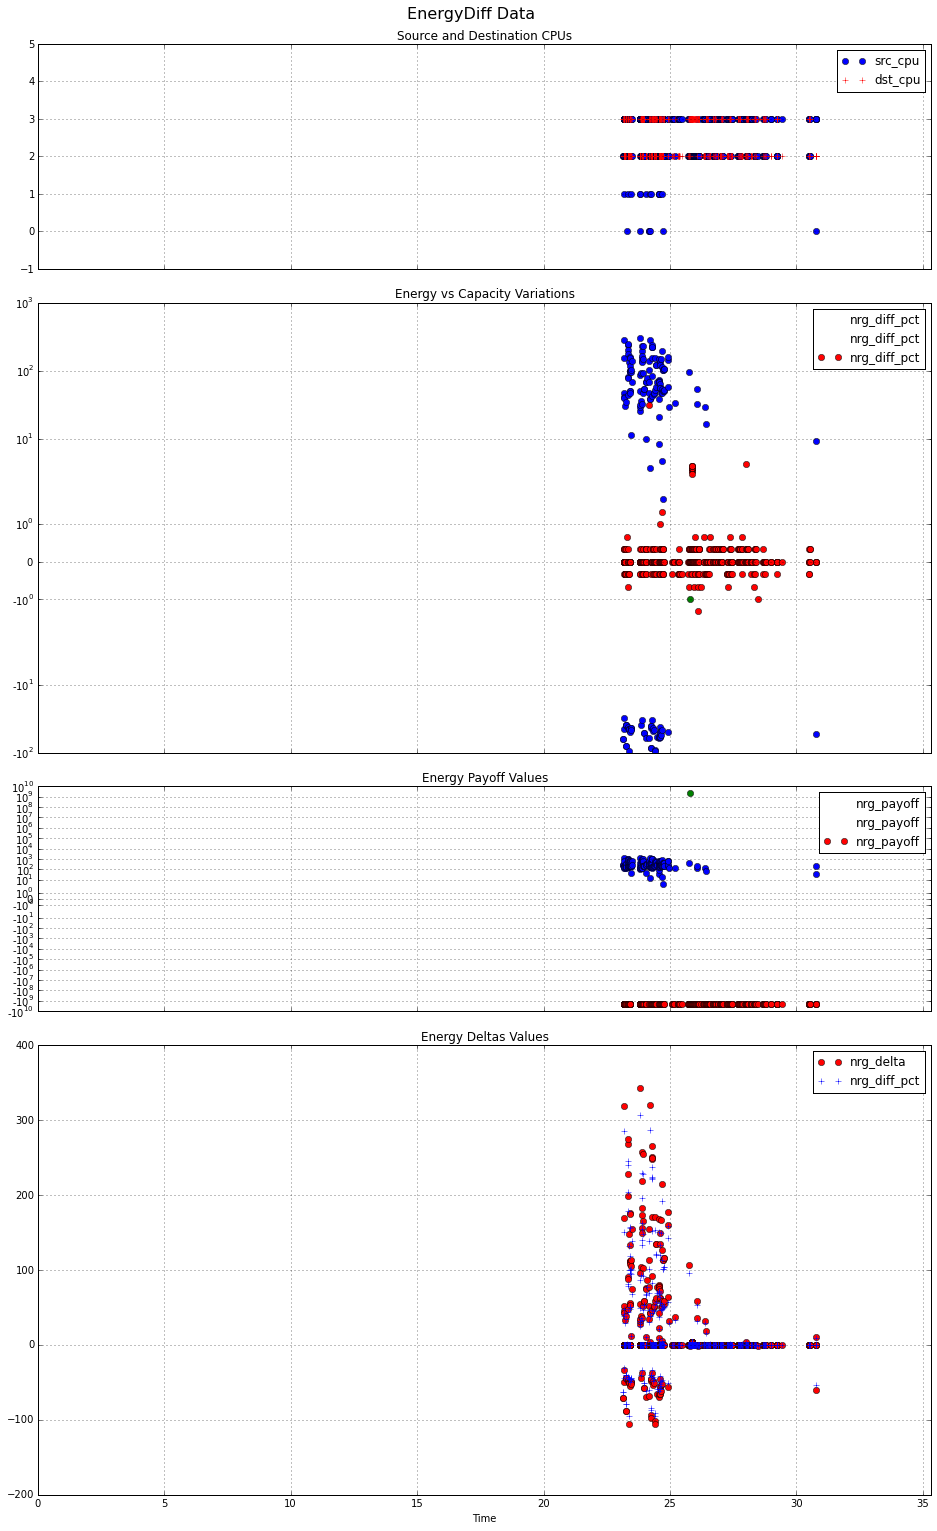

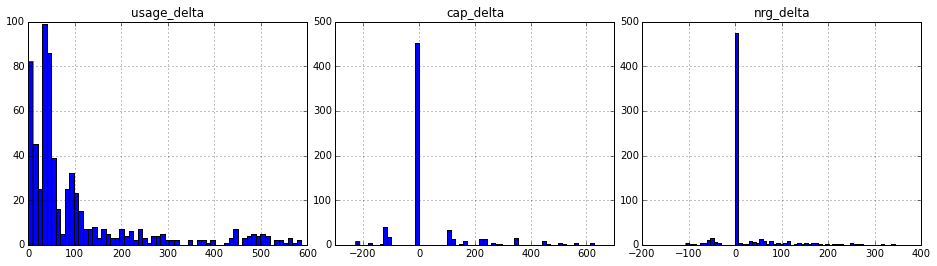

In [20]:
# Plots SchedTune's Energy-Diff Space Filtering
trace.analysis.eas.plotEDiffTime()